In [2]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train=pd.read_csv('ACT11_competition_training.csv', dtype={"MOLECULE": object, "Act": float})

                  

Get truth values and reshape

In [3]:
y=train['Act'].values
y.shape

(6399,)

In [4]:
y=np.reshape(y,(-1,1))
y.shape

(6399, 1)

In [5]:
train=train.drop(['Act', 'MOLECULE'], axis=1)

In [6]:
x=train.values

In [7]:
####Provided by MERCK
def r_square(X, Y):
    """ r^2 value defined by the competition host, r^2 = 1 indicates 100% prediction accuracy
    """
    avx = np.mean(X)
    avy = np.mean(Y)
    sum1, sumx, sumy = 0, 0, 0
    for i in range(len(X)):
        sum1 += (X[i] - avx)*(Y[i] - avy)
        sumx += (X[i] - avx)*(X[i] - avx)
        sumy += (Y[i] - avy)*(Y[i] - avy)
    print(len(X), sum1, sumx, sumy)
    return sum1*sum1/(sumx*sumy)

#### No Transformation. Loop five times and retain R2

In [8]:
for index_1 in range(10):
    print("-------------------- round "+str(index_1)+"-----------------------")
    x=train.values
    seed = round(np.random.uniform(1, len(x)))
    X_train, X_dev, Y_train, Y_dev = train_test_split(x, y, train_size = 0.80, random_state = seed)
    X_val, X_test, Y_val, Y_test = train_test_split(X_dev, Y_dev, train_size = 0.50, random_state = seed)

    X_placeholder = tf.placeholder(tf.float32, (None, X_train.shape[1]))
    Y_placeholder = tf.placeholder(tf.float32, (None, Y_train.shape[1]))

    # define parameters
    features = np.shape(X_train)[1]
    target_size = np.shape(X_train)[0]

    learning_rate = 0.001

    epochs = 900
    batch_size = 300

    batch_size_placeholder = tf.placeholder(tf.int64)

    # network parameters
    n_hidden_1 = 50
    n_hidden_2 = 25

    ds_train = tf.data.Dataset.from_tensor_slices(( X_placeholder, Y_placeholder )).shuffle(buffer_size=round(len(X_train) * 0.3)).batch(batch_size_placeholder)

    ds_test = tf.data.Dataset.from_tensor_slices(( X_placeholder, Y_placeholder )).batch( batch_size_placeholder )

    ds_iter = tf.data.Iterator.from_structure(ds_train.output_types, ds_train.output_shapes)

    next_x, next_y = ds_iter.get_next()

    train_init_op = ds_iter.make_initializer(ds_train)
    test_init_op = ds_iter.make_initializer(ds_test)

    # define placeholder for input vector X and target vector y
    keep_prob = tf.placeholder(tf.float32)

    # initialize weights and bias  
    weights = {'w1': tf.Variable(tf.truncated_normal([features, n_hidden_1], 0, 1, dtype=tf.float32)),
           'w2': tf.Variable(tf.truncated_normal([n_hidden_1, n_hidden_2], 0, 1, dtype=tf.float32)),
          'out': tf.Variable(tf.truncated_normal([n_hidden_2, 1], 0, 1, dtype=tf.float32))}

    biases = {'b1': tf.Variable(tf.truncated_normal([n_hidden_1], 0, 1, dtype=tf.float32)),
          'b2': tf.Variable(tf.truncated_normal([n_hidden_2], 0, 1, dtype=tf.float32)),
         'out': tf.Variable(tf.truncated_normal([1], 0, 1, dtype=tf.float32))}

    # Create model
    def multilayer_perceptron(x, weights, biases):
        # Hidden layer 1 with ReLu activation
        layer_1 = tf.add(tf.matmul(x, weights['w1']), biases['b1'])
        layer_1 = tf.nn.relu(layer_1)
        layer_1 = tf.nn.dropout(layer_1, keep_prob) 
    
        # Hidden layer 2 with ReLu activation
        layer_2 = tf.add(tf.matmul(layer_1, weights['w2']), biases['b2'])
        layer_2 = tf.nn.relu(layer_2)
        layer_2 = tf.nn.dropout(layer_2, keep_prob) 
    
        # Output layer with ReLu activation
        out_layer = tf.add(tf.matmul(layer_2, weights['out']), biases['out'])
        return out_layer
              
    # construct model
    y_pred = multilayer_perceptron(next_x, weights, biases)
    
    # define cost function(mean squred error) and optimizer(gradient descent)
    cost =  tf.losses.mean_squared_error(next_y, y_pred)
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

    # initialize variables
    init_op = tf.global_variables_initializer()

    with tf.Session() as sess:
        sess.run(init_op)
        for epoch in range(epochs):
    
            sess.run(train_init_op, feed_dict={X_placeholder: X_train, Y_placeholder: Y_train, batch_size_placeholder: batch_size})
            count = 0

            while True:
                try:
                    count += 1
                    _, c = sess.run((optimizer, cost), feed_dict={keep_prob: 0.75})
                except tf.errors.OutOfRangeError:
                    break
#            print('Epoch:', (epoch + 1), 'cost =', c)
        sess.run(test_init_op, feed_dict={X_placeholder: X_test, Y_placeholder: Y_test, batch_size_placeholder: len(X_test)})

        results, test_cost = sess.run((y_pred, cost), feed_dict={keep_prob: 1.0})

        print(test_cost)
        print('R^2:', r_square(np.reshape(results, (len(results),)), Y_test))



-------------------- round 0-----------------------


/home/kevinyan/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


0.26684064
640 [-0.27439375] 0.042271289301424986 [170.07633203]
R^2: [0.01047271]
-------------------- round 1-----------------------
0.2743149
640 [-0.2293674] 0.037354285246866015 [173.91947516]
R^2: [0.00809794]
-------------------- round 2-----------------------
0.27306953
640 [0.50432041] 0.30647475943071356 [174.42796664]
R^2: [0.00475776]
-------------------- round 3-----------------------
0.29079437
640 [4.3063445] 0.897780654532788 [185.22642949]
R^2: [0.11151784]
-------------------- round 4-----------------------
0.27804476
640 [0.85099426] 0.06687522772817811 [176.41169298]
R^2: [0.06138477]
-------------------- round 5-----------------------
0.27180532
640 [2.22712937] 0.2327537966190496 [177.38242231]
R^2: [0.12013887]
-------------------- round 6-----------------------
0.26793662
640 [3.31963257] 1.0090597402603265 [176.84512422]
R^2: [0.06175471]
-------------------- round 7-----------------------
0.28912577
640 [0.09014242] 0.008016216358921247 [184.41166136]
R^2: [0.

#### Binary Transformation. Loop five times and retain R2

In [9]:
for index_2 in range(10):
    print("-------------------- round "+str(index_2)+"-----------------------")    
    x = np.where(train > 0, 1, 0)
    seed = round(np.random.uniform(1, len(x)))
    X_train, X_dev, Y_train, Y_dev = train_test_split(x, y, train_size = 0.80, random_state = seed)
    X_val, X_test, Y_val, Y_test = train_test_split(X_dev, Y_dev, train_size = 0.50, random_state = seed)

    X_placeholder = tf.placeholder(tf.float32, (None, X_train.shape[1]))
    Y_placeholder = tf.placeholder(tf.float32, (None, Y_train.shape[1]))

    # define parameters
    features = np.shape(X_train)[1]
    target_size = np.shape(X_train)[0]
    
    learning_rate = 0.001

    epochs = 900
    batch_size = 300

    batch_size_placeholder = tf.placeholder(tf.int64)
    
    # network parameters
    n_hidden_1 = 50
    n_hidden_2 = 25

    ds_train = tf.data.Dataset.from_tensor_slices(( X_placeholder, Y_placeholder )).shuffle(buffer_size=round(len(X_train) * 0.3)).batch(batch_size_placeholder)

    ds_test = tf.data.Dataset.from_tensor_slices(( X_placeholder, Y_placeholder )).batch( batch_size_placeholder )
    
    ds_iter = tf.data.Iterator.from_structure(ds_train.output_types, ds_train.output_shapes)
    
    next_x, next_y = ds_iter.get_next()
    
    train_init_op = ds_iter.make_initializer(ds_train)
    test_init_op = ds_iter.make_initializer(ds_test)
    
    # define placeholder for input vector X and target vector y
    keep_prob = tf.placeholder(tf.float32)
    
    # initialize weights and bias  
    weights = {'w1': tf.Variable(tf.truncated_normal([features, n_hidden_1], 0, 1, dtype=tf.float32)),
               'w2': tf.Variable(tf.truncated_normal([n_hidden_1, n_hidden_2], 0, 1, dtype=tf.float32)),
              'out': tf.Variable(tf.truncated_normal([n_hidden_2, 1], 0, 1, dtype=tf.float32))}

    biases = {'b1': tf.Variable(tf.truncated_normal([n_hidden_1], 0, 1, dtype=tf.float32)),
              'b2': tf.Variable(tf.truncated_normal([n_hidden_2], 0, 1, dtype=tf.float32)),
             'out': tf.Variable(tf.truncated_normal([1], 0, 1, dtype=tf.float32))}

    # Create model
    def multilayer_perceptron(x, weights, biases):
        # Hidden layer 1 with ReLu activation
        layer_1 = tf.add(tf.matmul(x, weights['w1']), biases['b1'])
        layer_1 = tf.nn.relu(layer_1)
        layer_1 = tf.nn.dropout(layer_1, keep_prob) 
    
        # Hidden layer 2 with ReLu activation
        layer_2 = tf.add(tf.matmul(layer_1, weights['w2']), biases['b2'])
        layer_2 = tf.nn.relu(layer_2)
        layer_2 = tf.nn.dropout(layer_2, keep_prob) 
    
        # Output layer with ReLu activation
        out_layer = tf.add(tf.matmul(layer_2, weights['out']), biases['out'])
        return out_layer
              
    # construct model
    y_pred = multilayer_perceptron(next_x, weights, biases)
    
    # define cost function(mean squred error) and optimizer(gradient descent)
    cost =  tf.losses.mean_squared_error(next_y, y_pred)
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

    # initialize variables
    init_op = tf.global_variables_initializer()

    with tf.Session() as sess:
        sess.run(init_op)
        for epoch in range(epochs):
    
            sess.run(train_init_op, feed_dict={X_placeholder: X_train, Y_placeholder: Y_train, batch_size_placeholder: batch_size})
            count = 0

            while True:
                try:
                    count += 1
                    _, c = sess.run((optimizer, cost), feed_dict={keep_prob: 0.75})
                except tf.errors.OutOfRangeError:
                    break
#            print('Epoch:', (epoch + 1), 'cost =', c)
        sess.run(test_init_op, feed_dict={X_placeholder: X_test, Y_placeholder: Y_test, batch_size_placeholder: len(X_test)})

        results, test_cost = sess.run((y_pred, cost), feed_dict={keep_prob: 1.0})

        print(test_cost)
        print('R^2:', r_square(np.reshape(results, (len(results),)), Y_test))



-------------------- round 0-----------------------


/home/kevinyan/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


0.22497645
640 [25.07891769] 12.131691644654694 [180.94811567]
R^2: [0.28651156]
-------------------- round 1-----------------------
0.20185351
640 [39.15262427] 24.157151910140527 [181.11084318]
R^2: [0.35037376]
-------------------- round 2-----------------------
0.25554347
640 [5.0186372] 0.7731663693370132 [172.22505101]
R^2: [0.18914825]
-------------------- round 3-----------------------
0.2529075
640 [14.79956549] 5.552074959578189 [183.73842133]
R^2: [0.21470523]
-------------------- round 4-----------------------
0.28470558
640 [15.24529436] 29.83164321886855 [180.56847914]
R^2: [0.04314719]
-------------------- round 5-----------------------
0.25675768
640 [12.59107792] 6.591334931734666 [178.86789794]
R^2: [0.13446834]
-------------------- round 6-----------------------
0.2270544
640 [30.8785421] 16.161643125440047 [188.42999867]
R^2: [0.31309636]
-------------------- round 7-----------------------
0.21082878
640 [22.54865005] 11.085365778338074 [168.70629877]
R^2: [0.271869

# The model that we propose

#### Log Transformation. Loop five times and retain R2

In [10]:
for index_3 in range(10):
    print("-------------------- round "+str(index_3)+"-----------------------")    

    train = train.apply(lambda x: np.log(x+1))
    x = train.values
    seed = round(np.random.uniform(1, len(x)))
    X_train, X_dev, Y_train, Y_dev = train_test_split(x, y, train_size = 0.80, random_state = seed)
    X_val, X_test, Y_val, Y_test = train_test_split(X_dev, Y_dev, train_size = 0.50, random_state = seed)

    X_placeholder = tf.placeholder(tf.float32, (None, X_train.shape[1]))
    Y_placeholder = tf.placeholder(tf.float32, (None, Y_train.shape[1]))

    # define parameters
    features = np.shape(X_train)[1]
    target_size = np.shape(X_train)[0]

    learning_rate = 0.001

    epochs = 900
    batch_size = 300

    batch_size_placeholder = tf.placeholder(tf.int64)

    # network parameters
    n_hidden_1 = 50
    n_hidden_2 = 25

    ds_train = tf.data.Dataset.from_tensor_slices(( X_placeholder, Y_placeholder )).shuffle(buffer_size=round(len(X_train) * 0.3)).batch(batch_size_placeholder)

    ds_test = tf.data.Dataset.from_tensor_slices(( X_placeholder, Y_placeholder )).batch( batch_size_placeholder )

    ds_iter = tf.data.Iterator.from_structure(ds_train.output_types, ds_train.output_shapes)

    next_x, next_y = ds_iter.get_next()

    train_init_op = ds_iter.make_initializer(ds_train)
    test_init_op = ds_iter.make_initializer(ds_test)

    # define placeholder for input vector X and target vector y
    keep_prob = tf.placeholder(tf.float32)

    # initialize weights and bias  
    weights = {'w1': tf.Variable(tf.truncated_normal([features, n_hidden_1], 0, 1, dtype=tf.float32)),
           'w2': tf.Variable(tf.truncated_normal([n_hidden_1, n_hidden_2], 0, 1, dtype=tf.float32)),
          'out': tf.Variable(tf.truncated_normal([n_hidden_2, 1], 0, 1, dtype=tf.float32))}

    biases = {'b1': tf.Variable(tf.truncated_normal([n_hidden_1], 0, 1, dtype=tf.float32)),
          'b2': tf.Variable(tf.truncated_normal([n_hidden_2], 0, 1, dtype=tf.float32)),
         'out': tf.Variable(tf.truncated_normal([1], 0, 1, dtype=tf.float32))}

    # Create model
    def multilayer_perceptron(x, weights, biases):
        # Hidden layer 1 with ReLu activation
        layer_1 = tf.add(tf.matmul(x, weights['w1']), biases['b1'])
        layer_1 = tf.nn.relu(layer_1)
        layer_1 = tf.nn.dropout(layer_1, keep_prob) 
    
        # Hidden layer 2 with ReLu activation
        layer_2 = tf.add(tf.matmul(layer_1, weights['w2']), biases['b2'])
        layer_2 = tf.nn.relu(layer_2)
        layer_2 = tf.nn.dropout(layer_2, keep_prob) 
        
        # Output layer with ReLu activation
        out_layer = tf.add(tf.matmul(layer_2, weights['out']), biases['out'])
        return out_layer
              
    # construct model
    y_pred = multilayer_perceptron(next_x, weights, biases)

    # define cost function(mean squred error) and optimizer(gradient descent)
    cost =  tf.losses.mean_squared_error(next_y, y_pred)
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

    # initialize variables
    init_op = tf.global_variables_initializer()

    with tf.Session() as sess:
        sess.run(init_op)
        for epoch in range(epochs):
    
            sess.run(train_init_op, feed_dict={X_placeholder: X_train, Y_placeholder: Y_train, batch_size_placeholder: batch_size})
            count = 0

            while True:
                try:
                    count += 1
                    _, c = sess.run((optimizer, cost), feed_dict={keep_prob: 0.75})
                except tf.errors.OutOfRangeError:
                    break
#            print('Epoch:', (epoch + 1), 'cost =', c)
        sess.run(test_init_op, feed_dict={X_placeholder: X_test, Y_placeholder: Y_test, batch_size_placeholder: len(X_test)})

        results, test_cost = sess.run((y_pred, cost), feed_dict={keep_prob: 1.0})

        print(test_cost)
        print('R^2:', r_square(np.reshape(results, (len(results),)), Y_test))



-------------------- round 0-----------------------


/home/kevinyan/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


0.23457174
640 [13.3190856] 5.48568518861196 [169.27432592]
R^2: [0.19104112]
-------------------- round 1-----------------------
0.18930474
640 [44.87569262] 23.36120350507565 [178.55619552]
R^2: [0.48278325]
-------------------- round 2-----------------------
0.19495007
640 [38.72409361] 20.187079587941753 [181.09791951]
R^2: [0.41018103]
-------------------- round 3-----------------------
0.17077231
640 [44.90389045] 27.797440629818034 [166.06855764]
R^2: [0.43679304]
-------------------- round 4-----------------------
0.20687433
640 [27.6337272] 14.691699228164302 [172.58509562]
R^2: [0.30116439]
-------------------- round 5-----------------------
0.1577361
640 [53.52184868] 35.20855031744672 [170.86965912]
R^2: [0.47615584]
-------------------- round 6-----------------------
0.15188622
640 [64.18155803] 42.80655472546791 [182.15933504]
R^2: [0.52827347]
-------------------- round 7-----------------------
0.14907596
640 [69.97442868] 52.569411761526 [173.98515689]
R^2: [0.53534457]

In [4]:
trials = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
notrans=[0.01047271, 0.00809794, 0.00475776, 0.11151784, 0.06138477, 0.12013887, 0.06175471, 0.00549668, 0.0037739, 0.13213858]
bintrans=[0.28651156,0.35037376,0.18914825, 0.21470523,0.04314719,0.13446834,0.31309636,0.27186905,0.00396941,0.23992141]
logtrans=[0.19104112, 0.48278325, 0.41018103, 0.43679304, 0.30116439, 0.47615584, 0.52827347, 0.53534457, 0.46480323,0.44830295]

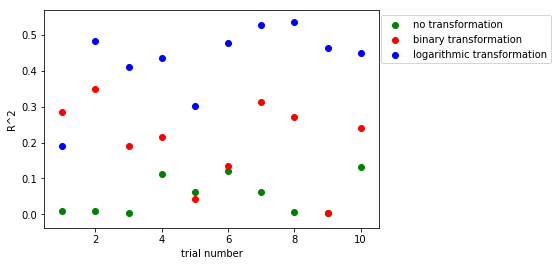

In [24]:
plt.scatter(trials, notrans, c='g')
plt.scatter(trials, bintrans, c = 'r')
plt.scatter(trials, logtrans, c = 'b')
plt.xlabel('trial number')
plt.ylabel('R^2')
plt.legend(('no transformation', 'binary transformation', 'logarithmic transformation'), bbox_to_anchor=(1.53, 1.0))
